In [136]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tools import plot_decision_regions

## ADALINE

* 가중치 생성: 샘플 feature의 수 + 1.
* 훈련: 경사 하강법 이용
  * 전체 샘플을 한번 순회할때마다 샘플 전체를 기반으로 한번 가중치 업데이트
  * loss function: SumSquaredError: $J(\boldsymbol{w})=\frac{1}{2}\sum_{i}(y^{(i)}-\phi(\boldsymbol{z}^{(i)}))^2$
    * 퍼셉트론과 달리 $\boldsymbol{z}$ 를 타겟과 비교한다.
    * $\phi$는 identity function
  * $\boldsymbol{w}=\boldsymbol{w} + \Delta \boldsymbol{w} =\boldsymbol{w} -\eta\nabla J(\boldsymbol{w}) = \boldsymbol{w} + \eta\sum_{i}(y^{(i)}-\phi(\boldsymbol{w\top x}^{(i)}))\boldsymbol{x}^{(i)}$
* prediction: 퍼셉트론과 마찬가지로 계단함수를 본뜬 임계함수를 이용해 출력 결정. $\pm1$

In [141]:
class ADALINE:
    """ADAptive LInear NEuron
    퍼셉트론의 개선판. 이진 분류를 수행하며 가중치 학습에 경사하강법을 이용한다.
    """
    def __init__(self, num_features, learning_rate):
        # 가중치 생성
        self.w = np.random.RandomState(1).normal(0, 0.01, size=num_features+1)
        self.eta = learning_rate
        
    def calc_z(self, x):
        z = np.dot(x, self.w[1:]) + self.w[0]
        return z
    
    def activation(self, z):
        return z
    
    def threshold_function(self, z):
        return np.where(z >= 0, 1, -1)
    
    def __call__(self, x):
        z = self.activation(self.calc_z(x))
        return self.threshold_function(z)
    
    def fit(self, x, y, epochs):
        """주어지는 데이터 샘플을 이용해 가중치 훈련"""
        def calc_cost_gradient_prediction(x, y):
            """sample별 cost(squared error), gradient, 예측값 계산"""
            z = self.calc_z(x)
            error = y - self.activation(z)
            cost = (error ** 2) / 2.
            gradient = -error * np.concatenate([(1.,), x])
            prediction = self.threshold_function(z)
            return cost, gradient, prediction
        
        self._loss_history = []
        self._accuracy_history = []
            
        for epoch in range(epochs):
            loss = 0.
            gradient_sum = 0.
            correct_pred = []
            for sample, target in zip(x, y):
                cost, gradient, prediction = calc_cost_gradient_prediction(sample, target)
                loss += cost  # sum squared error 계산
                gradient_sum += gradient  # batch gradient descent를 적용하기위해 그래디언트 누적
                correct_pred.append(int(prediction == target))  # 정확도 계산
            
            accuracy = sum(correct_pred)/len(correct_pred)
            self._loss_history.append(loss)
            self._accuracy_history.append(accuracy)
            
            # 가중치 갱신
            d_w = -self.eta * gradient_sum
            self.w += d_w
            
            print(f'{epoch} epoch - loss: {loss:.4f}, acc: {accuracy:.4f}')    

### 학습

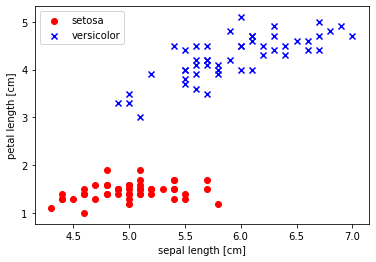

In [7]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0, 2]].values

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:, 0], X[50:, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

#### 적당한 학습률

0 epoch - loss: 51.0812, acc: 0.5000
1 epoch - loss: 46.0987, acc: 0.5000
2 epoch - loss: 43.1835, acc: 0.5000
3 epoch - loss: 40.5384, acc: 0.5000
4 epoch - loss: 38.0689, acc: 0.6700
5 epoch - loss: 35.7601, acc: 0.9400
6 epoch - loss: 33.6013, acc: 0.9800
7 epoch - loss: 31.5829, acc: 0.9900
8 epoch - loss: 29.6957, acc: 1.0000
9 epoch - loss: 27.9311, acc: 1.0000


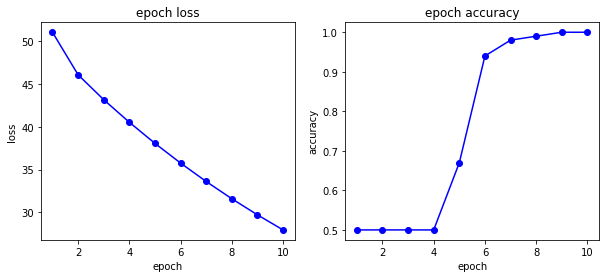

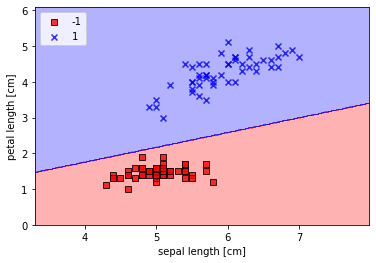

In [142]:
adaline = ADALINE(2, 0.0003)
adaline.fit(X, y, 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax_0, ax_1 = ax[:2]
ax_0.plot(range(1, 11), adaline._loss_history, 'b', marker='o')
ax_0.set_title('epoch loss')
ax_0.set_xlabel('epoch')
ax_0.set_ylabel('loss')

ax_1.plot(range(1, 11), adaline._accuracy_history, 'b', marker='o')
ax_1.set_title('epoch accuracy')
ax_1.set_xlabel('epoch')
ax_1.set_ylabel('accuracy')
plt.show()

plot_decision_regions(X, y, adaline, x_label='sepal length [cm]', y_label='petal length [cm]')

#### 너무 높은 학습률: 가중치가 너무 크게 변화하며 발산함 (큰 가중치 변화 -> 에러 증가 -> 더욱 큰 가중치 변화 -> 에러 증가 -> ... 악순환)

0 epoch - loss: 51.0812, acc: 0.5000
1 epoch - loss: 3212.0017, acc: 0.5000
2 epoch - loss: 5006791.2872, acc: 0.5000
3 epoch - loss: 7811818375.7816, acc: 0.5000
4 epoch - loss: 12188352557082.2734, acc: 0.5000
5 epoch - loss: 19016819254863852.0000, acc: 0.5000
6 epoch - loss: 29670902025401151488.0000, acc: 0.5000
7 epoch - loss: 46293884124485648384000.0000, acc: 0.5000
8 epoch - loss: 72229813084097838971879424.0000, acc: 0.5000
9 epoch - loss: 112696223201635989280029409280.0000, acc: 0.5000


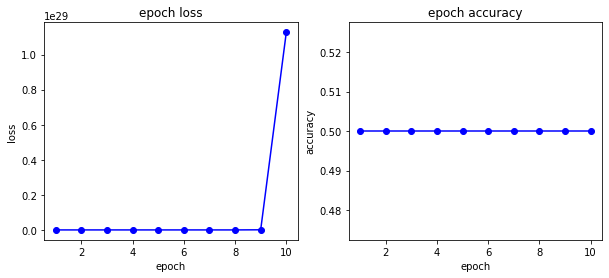

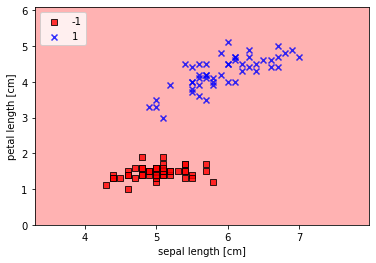

In [143]:
adaline = ADALINE(2, 0.01)
adaline.fit(X, y, 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax_0, ax_1 = ax[:2]
ax_0.plot(range(1, 11), adaline._loss_history, 'b', marker='o')
ax_0.set_title('epoch loss')
ax_0.set_xlabel('epoch')
ax_0.set_ylabel('loss')

ax_1.plot(range(1, 11), adaline._accuracy_history, 'b', marker='o')
ax_1.set_title('epoch accuracy')
ax_1.set_xlabel('epoch')
ax_1.set_ylabel('accuracy')
plt.show()

plot_decision_regions(X, y, adaline, x_label='sepal length [cm]', y_label='petal length [cm]')

#### 너무 낮은 학습률: 가중치 갱신이 미비하여 학습이 안됨

0 epoch - loss: 51.0812, acc: 0.5000
1 epoch - loss: 51.0812, acc: 0.5000
2 epoch - loss: 51.0812, acc: 0.5000
3 epoch - loss: 51.0811, acc: 0.5000
4 epoch - loss: 51.0811, acc: 0.5000
5 epoch - loss: 51.0811, acc: 0.5000
6 epoch - loss: 51.0811, acc: 0.5000
7 epoch - loss: 51.0810, acc: 0.5000
8 epoch - loss: 51.0810, acc: 0.5000
9 epoch - loss: 51.0810, acc: 0.5000


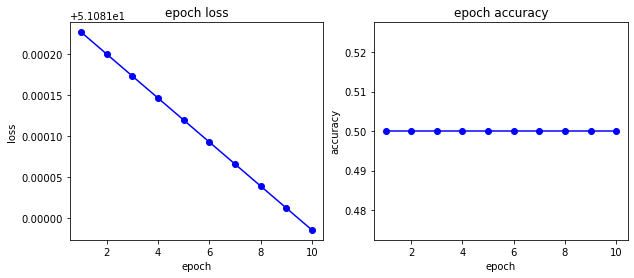

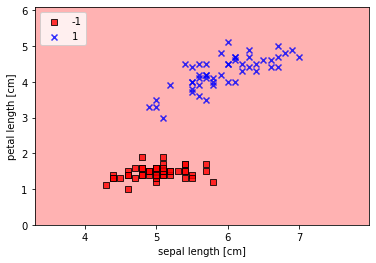

In [144]:
adaline = ADALINE(2, 0.000000001)
adaline.fit(X, y, 10)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax_0, ax_1 = ax[:2]
ax_0.plot(range(1, 11), adaline._loss_history, 'b', marker='o')
ax_0.set_title('epoch loss')
ax_0.set_xlabel('epoch')
ax_0.set_ylabel('loss')

ax_1.plot(range(1, 11), adaline._accuracy_history, 'b', marker='o')
ax_1.set_title('epoch accuracy')
ax_1.set_xlabel('epoch')
ax_1.set_ylabel('accuracy')
plt.show()

plot_decision_regions(X, y, adaline, x_label='sepal length [cm]', y_label='petal length [cm]')